# Pan-cancer (PC) plasma proteome Paper — Figure 2-1

This Jupyter Notebook (with Python 3 kernel) contained the code for the proteomic analysis of PC proteome clustering

Input files:  
* The categorical clinical file: category.csv
* The continuous clinical fille: continuous.csv
* The PC proteome file: proteome.csv
* The PC ssGSEA file: ssgsea.csv

Output figures:  
* Figure 2a, 2b, 2c, S2, S3c, S3d

In [1]:
from utils import *
paths = ['../figure/figure2', '../documents/figure2']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

R[write to console]: 'select()' returned 1:1 mapping between keys and columns

R[write to console]: `universe` is not in character and will be ignored...

R[write to console]: 'select()' returned 1:1 mapping between keys and columns

R[write to console]: `universe` is not in character and will be ignored...

R[write to console]: 'select()' returned 1:1 mapping between keys and columns

R[write to console]: `universe` is not in character and will be ignored...

R[write to console]: 'select()' returned 1:1 mapping between keys and columns

R[write to console]: `universe` is not in character and will be ignored...

R[write to console]: 'select()' returned 1:1 mapping between keys and columns

R[write to console]: `universe` is not in character and will be ignored...

R[write to console]: 'select()' returned 1:1 mapping between keys and columns

R[write to console]: `universe` is not in character and will be ignored...

R[write to console]: 'select()' returned 1:1 mapping between keys and 

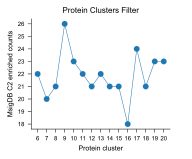

In [80]:
a.set_param('group', dataset_type='proteome', group_name='Proteome cluster', thresh=.8)
sig_deps = a.table.query("anova_fdr<0.01").index
df = a.merge_data_group(sig_deps).apply(scipy.stats.zscore, nan_policy='omit').groupby(['Proteome cluster']).mean().T
from sklearn.cluster import KMeans
ora_results = {}
protein_clusters = {}
for n in range(6, 21, 1):
    km = KMeans(n_clusters=n, random_state=42)
    km.fit(df)
    out = pd.Series(km.labels_, index=df.index).astype(str).rename('Protein cluster')
    protein_clusters[n] = out
    o = ora('clusterprofiler')
    ora_ = out.reset_index().groupby('Protein cluster').apply(lambda x: o.run(x['Gene'].tolist(), db=['hallmark']))
    ora_results[n] = ora_

count_ = {k: len(v) for k, v in ora_results.items()}
plotdata = pd.Series(count_).rename_axis('Protein cluster').rename('MsigDB C2 enriched counts')
plotdata.to_csv('../documents/figure2/FigS3c.csv')

ax = scatterplot(plotdata, ticklabels_format=[], ticklabels_hide=[], linewidth=0.1, edgecolor='white', figsize=(2.5, 2))
ax = lineplot(plotdata, ticklabels_format=[], ticklabels_hide=[], ax=ax, title='Protein Clusters Filter')
ax.set_xticks(plotdata.index.tolist())
ax.set_xticklabels(plotdata.index.tolist())
ax.get_figure().savefig('../figure/figure2/FigS3c.pdf', bbox_inches='tight')

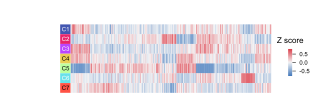

In [81]:
df = a.merge_data_group(sig_deps).apply(scipy.stats.zscore, nan_policy='omit').groupby(['Proteome cluster']).mean().T
protein_order = protein_clusters[9].sort_values().index
plotdata = df.loc[protein_order].T
fig = heatmap(plotdata, lut={'Proteome cluster': a._color_map['Proteome cluster']}, figsize=(4, 2.1), vmax=.8, vmin=-.8, yticklabels=False, colors_ratio=.04, legend=False, cbar_pos=(1, .5, .015, .18))
plotdata.to_csv('../documents/figure2/Fig2a_middle_panel.csv')

ax = fig.ax_row_colors
ax.set_xticklabels('')
ax.set_xticks([])
text_colors = 'wwwkkwk'
for i, text_color in zip(range(1, 8, 1), text_colors):
    ax.text(x=.15, y=i-.3, s=f'C{i}', c=text_color)

fig.ax_cbar.set_title('Z score')
fig.savefig('../figure/Figure2/Fig2a_middle_panel.pdf', bbox_inches='tight')

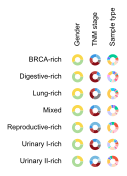

In [13]:
def pieplot(x, ax, color, p=0.4, label=None, **kwargs):
    '''
    Draw a pieplot;
    parameter: x: a series contain label and values(to calculate percentage); p: center radius(percentage)
    '''

    x = x.to_frame().reset_index()
    my_circle = plt.Circle((0, 0), p, color='white')
    ax.pie(x.iloc[:, 1], labels=label, colors=color, **kwargs)
    ax.add_artist(my_circle)
    return ax

clinical_indicators = ['Gender', 'TNM stage', 'Sample type']
colors = [a._color_map[i] for i in clinical_indicators]
clusters = np.unique(a.category.query("`Proteome cluster`==`Proteome cluster`")['Proteome cluster'])
nrows = len(clusters)
ncols = len(clinical_indicators)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 0.3, nrows * 0.3))

for i, (ax, clinical_indicator, color) in enumerate(zip(axs, clinical_indicators, colors)):
    df = a.category[['Proteome cluster', clinical_indicator]].query("`Proteome cluster`==`Proteome cluster`").fillna('znot-evaluated')
    df.loc[:, 'values']= 1
    table = pd.pivot_table(df, values='values', index=clinical_indicator, columns='Proteome cluster', aggfunc=np.size, fill_value=0).loc[df[clinical_indicator].unique()]
    order_ = np.sort(table.index)
    palette = [color.get(k, 'gray') for k in order_]
    for j, proteome_cluster in enumerate(clusters):
        pieplot(table.loc[order_, proteome_cluster].dropna(), ax=axs[j][i], color=palette)


pad = 1
for ax, col in zip(axs[0], clinical_indicators):
    ax.annotate(col, xy=(0.5, 1.5), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                ha='center', va='baseline', fontsize=7, rotation=90)

for ax, row in zip(axs[:,0], clusters):
    ax.annotate(row, xy=(0, 0), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center', fontsize=7)

fig.savefig('../figure/figure2/Fig2a_left_panel.pdf', bbox_inches='tight')

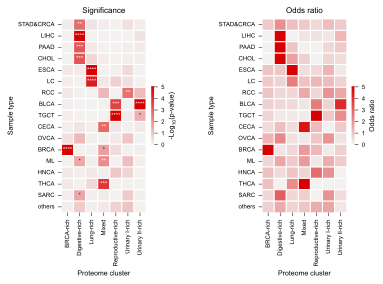

In [14]:
from collections import defaultdict
df = a.category[['Sample type for Figure 2', 'Proteome cluster']].dropna()
table = pd.crosstab(df.iloc[:, 0], df.iloc[:, 1])

pvalue_out = defaultdict(dict)
statistic_out = defaultdict(dict)
for tumor_type in table.index:
    for cluster in table.columns:
        tmp_table = table.rename(columns=lambda x: x if x == cluster else 'zothers', index=lambda x: x if x == tumor_type else 'zothers').groupby('Sample type for Figure 2').sum().groupby('Proteome cluster', axis=1).sum()
        res = scipy.stats.fisher_exact(tmp_table, alternative='greater')
        pvalue_out[tumor_type][cluster] = res[1]
        statistic_out[tumor_type][cluster] = res[0]
pvalue_table = pd.DataFrame().from_dict(pvalue_out, orient='index')
statistic_table = pd.DataFrame().from_dict(statistic_out, orient='index')

order_ = ['STAD&CRCA', 'LIHC', 'PAAD', 'CHOL', 'ESCA', 'LC', 'RCC', 'BLCA', 'TGCT', 'CECA', 'OVCA', 'BRCA', 'ML', 'HNCA', 'THCA', 'SARC', 'others']
for table_out, name, file_name in zip([pvalue_table, statistic_table], ['pvalue', 'statistic'], ['2a', 'S3d']):
    table_out.loc[order_].to_csv(f'../documents/figure2/Source_data_Fig{file_name}.csv')

from utils.eplot.base import prob_star
plotdata = pvalue_table.loc[order_]
annot = plotdata.applymap(lambda x: prob_star(x)).replace('na', '')
fig, axs = plt.subplots(1, 2, figsize=(5.5, 3.5))
plt.subplots_adjust(wspace=.9)
ax = heatmap(-np.log10(plotdata), cmap=R_CMAP, vmax=5, vmin=0, center=2.5, figsize=(2, 4), annot=annot, fmt='', xticklabels=True, ax=axs[0], linewidth=1, xlabel='Proteome cluster', ylabel='Sample type', cbar_kws={'shrink': 0.3, 'label': '-$\mathregular{Log_{10}}$(p-value)', 'values': np.linspace(0, 5, 201), 'ticks': range(0, 6, 1)})
ax.set_title('Significance')

plotdata = statistic_table.loc[order_]
ax = heatmap(plotdata, cmap=R_CMAP, vmax=5, vmin=0, center=2.5, figsize=(2, 4), xticklabels=True, ax=axs[1], linewidth=1, xlabel='Proteome cluster', ylabel='Sample type', cbar_kws={'shrink': 0.3, 'label': 'Odds ratio', 'values': np.linspace(0, 5, 201), 'ticks': range(0, 6, 1)})
ax.set_title('Odds ratio')

ax.get_figure().savefig('../figure/figure2/FigS3d-Fig2a_upper_right_panel.pdf', bbox_inches='tight')

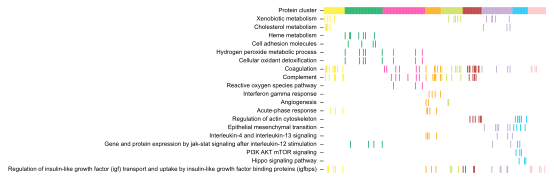

In [126]:
o = ora('clusterprofiler')
ora_ = protein_clusters[9].reset_index().groupby('Protein cluster').apply(lambda x: o.run(x['Gene'].values.tolist(), db=['hallmark', 'kegg', 'reac', 'go']))
ora_.to_csv('../documents/figure2/Protein_cluster_ORA_table.csv')

term = ['HALLMARK_XENOBIOTIC_METABOLISM', 'Cholesterol metabolism', 'HALLMARK_HEME_METABOLISM', 'Cell adhesion molecules', 'hydrogen peroxide metabolic process', 'cellular oxidant detoxification', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'acute-phase response', 'Regulation of actin cytoskeleton',  'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'Interleukin-4 and Interleukin-13 signaling', 'Gene and protein expression by JAK-STAT signaling after Interleukin-12 stimulation', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'Regulation of Insulin-like Growth Factor (IGF) transport and uptake by Insulin-like Growth Factor Binding Proteins (IGFBPs)']
plotdata = ora_.query("Description in @term").set_index('Description', append=True).droplevel(1)['geneID'].str.split('/').explode().to_frame()
plotdata = plotdata.assign(value=plotdata.index.get_level_values(0).astype(int)+1).set_index('geneID', append=True).unstack().droplevel(0, 1).reindex(sig_deps, axis=1).groupby('Description').sum().replace(0, np.nan).loc[pd.unique(term), protein_order] - 1
plotdata.to_csv('../documents/figure2/Source_data_Fig2a_bottom_panel.csv')

n = plotdata.shape[0]
fig, axs = plt.subplots(n+1, 1, figsize=(4, (n+1)*0.15))
palette = a._color_map['Protein group']
heatmap(protein_clusters[9].to_frame().T[protein_order].astype(int), cmap=list(palette.values()), vmax=8, vmin=0, center=4, ax=axs[0], cbar=False)
axs[0].set_yticklabels(axs[0].get_yticklabels(), rotation=0)
name_mapping_ = lambda x: x.split('_', maxsplit=1)[-1].capitalize()

import re
rep = {'_': ' ', 'Pi3k': 'PI3K', 'Regulation of insulin-like growth factor (igf) transport and uptake by insulin-like growth factor binding proteins (igfbps)': 'Regulation of IGF transport and uptake by IGFBPs', 'akt': 'AKT', 'mtor': 'mTOR'}
pattern = re.compile("|".join(rep))

for ax, (k, v) in zip(axs[1:], plotdata.iterrows()):
    value_unique = pd.unique(v.dropna())
    mapping_ = dict(zip(value_unique, range(len(value_unique))))
    cmap = [palette[str(i)[:1]] for i in value_unique]
    heatmap(v.apply(lambda x: mapping_.get(x, x)).to_frame().T, ax=ax, cbar=False, cmap=cmap, vmax=None, vmin=None, center=None)
    yticklabel = pattern.sub(lambda m: rep[re.escape(m.group(0))], ''.join(map(name_mapping_, [k])))
    ax.set_yticklabels([yticklabel], rotation=0)

fig.savefig('../figure/figure2/Fig2a_bottom_panel.pdf', bbox_inches='tight')

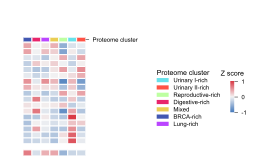

In [11]:
term_ssgsea = ['HALLMARK_XENOBIOTIC_METABOLISM', 'GO_REGULATION_OF_CHOLESTEROL_METABOLIC_PROCESS', 'HALLMARK_HEME_METABOLISM', 'KEGG_CELL_ADHESION_MOLECULES_CAMS', 'GO_HYDROGEN_PEROXIDE_METABOLIC_PROCESS', 'GO_CELLULAR_OXIDANT_DETOXIFICATION', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'GO_ACUTE_PHASE_RESPONSE', 'KEGG_REGULATION_OF_ACTIN_CYTOSKELETON', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'REACTOME_INTERLEUKIN_4_AND_INTERLEUKIN_13_SIGNALING', 'REACTOME_GENE_AND_PROTEIN_EXPRESSION_BY_JAK_STAT_SIGNALING_AFTER_INTERLEUKIN_12_STIMULATION', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_TRANSPORT_AND_UPTAKE_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS_']

a.set_param('group', dataset_type='ssgsea', group_name='Proteome cluster', statistic_method='no')
plotdata = a.merge_data_group(term_ssgsea).apply(scipy.stats.zscore).groupby('Proteome cluster').mean().T.reindex(term_ssgsea)
plotdata.to_csv('../documents/figure2/Fig2a_right-bottom_panel.csv')

fig = heatmap(plotdata, figsize=(2, 2.4), lut={'Proteome cluster': a._color_map['Proteome cluster']}, yticklabels=False, linewidth=1, linecolor='white')
fig.ax_cbar.set_title('Z score', fontsize=7)
fig.savefig('../figure/figure2/Fig2a_right-bottom_panel.pdf')

Text(0.5, 1.0, 'Z score')

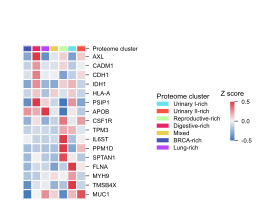

In [3]:
a._data['tmp'] = 2 ** a.proteome
a.set_param('group', dataset_type='tmp', group_name='Proteome cluster', statistic_method='no')
cag = a.CAG.index
cag_plot_gene = a.table.reindex(cag).query("alexandergovern_fdr<0.01").index.unique()
plotdata = a.merge_data_group(cag_plot_gene).apply(scipy.stats.zscore, nan_policy='omit').groupby('Proteome cluster').mean().T

from utils.function import large_than_n_value
cag_plot_gene_order = large_than_n_value(plotdata).sort_values(plotdata.columns.tolist(), ascending=False).index
plotdata = plotdata.loc[cag_plot_gene_order]
plotdata.to_csv('../documents/figure2/Source_data_Fig2b.csv')

fig = heatmap(plotdata, lut={'Proteome cluster': a._color_map['Proteome cluster']}, vmax=.5, vmin=-.5, figsize=(2, 3), linewidth=1, linecolor='white')
fig.ax_cbar.set_title('Z score', fontsize=7)
fig.savefig('../figure/figure2/Fig2b.pdf', bbox_inches='tight')

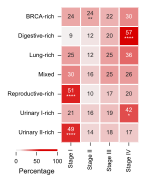

In [4]:
from collections import defaultdict
from utils.eplot.base import prob_star

tmp = a.category[['TNM stage', 'Proteome cluster']].dropna()
table = pd.crosstab(tmp.iloc[:, 0], tmp.iloc[:, 1]).T
plotdata = table.div(table.sum(axis=1), axis=0) * 100
# plotdata.to_csv('../documents/figure2/Fig2c.csv')

out = defaultdict(dict)
for cluster_ in table.index:
    for tnm_stage in table.columns:
        table_copy = table.rename(columns=lambda x: x if x == tnm_stage else 'zothers', index=lambda x: x if x == cluster_ else 'zothers')
        table_copy = table_copy.groupby('TNM stage', axis=1).sum().groupby('Proteome cluster').sum()
        out[cluster_][tnm_stage] = scipy.stats.fisher_exact(table_copy, alternative='greater')[1]
star_df = pd.DataFrame().from_dict(out, orient='index').applymap(prob_star).replace('na', '')
linkage_df = star_df.applymap(lambda x: '\n' if x != '' else '')
annot_df = plotdata.astype(int).astype(str) + linkage_df + star_df

ax = heatmap(plotdata, vmax=None, vmin=None, center=None, cmap=R_CMAP, annot=annot_df, fmt='', square=True, linewidth=1, linecolor='white', figsize=(2.5, 3.5), xticklabels=True, cbar_kws={'orientation': 'horizontal', 'shrink': 0.3, 'anchor': (-.15, 1.8), 'label': 'Percentage', 'values': range(101), 'ticks': [0, 50, 100]})
# ax.get_figure().savefig('../figure/figure2/Fig2c.pdf', bbox_inches='tight')


In [7]:
import joblib

mapping_ = joblib.load('../document/unit.joblib')
proteome_clusters = ['Digestive-rich', 'BRCA-rich', 'Lung-rich', 'Mixed', 'Reproductive-rich', 'Urinary I-rich', 'Urinary II-rich']
a.set_param('group', dataset_type='continuous', group_name='Proteome cluster', part_element=proteome_clusters)
df = a.table.query("anova_pvalues<0.01").iloc[:, :6]
df = np.argsort(df).applymap(lambda x: 1 if x != 5 else 0)
indicators = df.sort_values(df.columns.tolist()).index[:-1]
fig, axs = plt.subplots(8, 4, figsize=(9, 8))
plt.subplots_adjust(wspace=.5, hspace=.5)

for i, (indicator, ax) in enumerate(zip(indicators, axs.ravel())):
    if i > 24:
        ticklabels_hide=[]
        labels_hide=[]
    else:
        ticklabels_hide=['x']
        labels_hide=['x']
    a.cate(indicator, box_pairs=None, quantile=True, stripsize=1, category_type=['box', 'strip'], spines_hide=['top', 'right'], ticklabels_hide=ticklabels_hide, labels_hide=labels_hide, ax=ax)[0]

    ylim_down, ylim_up = ax.get_ylim()
    ax.set_ylim([ylim_down, ylim_up*1.2])
    ax.plot((0, 6), (ylim_up, ylim_up), c='black')
    ax.plot((0, 0), (ylim_up*0.95, ylim_up), c='black')
    ax.plot((6, 6), (ylim_up*0.95, ylim_up), c='black')
    ax.text(0.25, ylim_up*1.05, s="ANOVA p-value = {:.2e}".format(a.table.loc[indicator, 'anova_pvalues']))

    ylabel = mapping_.get(indicator, ' ')
    ax.set_ylabel(ylabel)
    if i > 24:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.savefig('../figure/figure2/FigS2.pdf', bbox_inches='tight')